# Daily Spotify Listenings & Weather Analysis

## Project Overview
This project aims to analyze the relationship between **my daily Spotify listenings** and the **weather conditions** on those days (sunny, rainy, cloudy, etc.). The goal is to uncover patterns in my music preferences based on weather. By analyzing this data, I hope to discover if weather influences my mood and music choices.

### Key Questions
1. How do my music preferences change based on weather conditions (e.g., sunny, rainy, cloudy)?
2. Are there certain genres or moods I gravitate towards depending on the weather?
3. Can I identify patterns in my Spotify listening behavior related to specific weather events?

### Data Sources
- **Spotify Listenings Data** (from `my_data.json`) with columns:
  - `ts`: Timestamp (date & time)
  - `master_metadata_track_name`, etc.
  - `spotify_track_uri`: Unique track URI
  - `ms_played`: Duration (milliseconds) of the play

- **Weather Data** (fetched from an API or a CSV), containing:
  - `date`: Date of interest
  - `condition`: e.g., 'sunny', 'rainy', 'cloudy'
  - `temperature`, `humidity` (optional)

### Project Plan
1. **Data Collection**: Read Spotify data, read/fetch Weather data.
2. **Cleaning & Merging**: Convert timestamps, merge daily weather with daily Spotify info.
3. **EDA**: Explore how genres vary by weather.
4. **Visualization**: Bar plots for genre vs. weather, scatter for temperature vs. listening time, etc.
5. **ML** (Optional): Predict whether I'll listen to energetic or relaxing songs based on weather.

Let's get started!

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#For ML
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Loading Spotify Data
Here's an example structure:

```json
[
  {
    "ts": "2024-12-26T19:12:34Z",
    "platform": "ios",
    "ms_played": 287189,
    "conn_country": "TR",
    "ip_addr": "178.240.231.177",
    "master_metadata_track_name": "Mikrop",
    "master_metadata_album_artist_name": "Serdar Ortaç",
    "master_metadata_album_album_name": "Kara Kedi",
    "spotify_track_uri": "spotify:track:0cbjvKpGFY7UrazvtVQ9W6",
    "episode_name": null,
    "episode_show_name": null,
    "spotify_episode_uri": null,
    "reason_start": "clickrow",
    "reason_end": "fwdbtn",
    "shuffle": true,
    "skipped": true,
    "offline": false,
    "offline_timestamp": 1735240067,
    "incognito_mode": false
  },
  ...
]
```

Let's load it into a DataFrame:

In [2]:
# Loading Spotify data from JSON
spotify_json_path = 'my_data.json'

df_spotify = pd.read_json(spotify_json_path)
print("Number of Spotify records loaded:", len(df_spotify))
df_spotify.head()

Number of Spotify records loaded: 3616


,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2024-07-30T17:27:41Z,ios,133755,TR,176.33.67.245,DOĞUŞTAN BERİ HAKLIYIM (tmm),Lvbel C5,DOĞUŞTAN BERİ HAKLIYIM (tmm),spotify:track:2M7BEoyAzxLBKgnFQqUGmF,None,None,None,clickrow,trackdone,True,False,False,1722360328,False
1,2024-07-30T17:32:04Z,ios,267354,TR,176.33.67.245,We Are The People,Empire Of The Sun,Walking On A Dream,spotify:track:6DG1vjbBFKJWVeihm4hK0X,None,None,None,trackdone,trackdone,True,False,False,1722360457,False
2,2024-07-30T17:34:10Z,ios,5504,TR,176.33.67.245,DOĞUŞTAN BERİ HAKLIYIM (tmm),Lvbel C5,DOĞUŞTAN BERİ HAKLIYIM (tmm),spotify:track:2M7BEoyAzxLBKgnFQqUGmF,None,None,None,trackdone,endplay,True,True,False,1722360719,False
3,2024-07-30T17:34:11Z,ios,874,TR,176.33.67.245,nE !?,Lvbel C5,#1,spotify:track:1Ma4fLShd0hpZSNH37mEkR,None,None,None,clickrow,endplay,True,True,False,1722360850,False
4,2024-07-31T13:36:38Z,ios,3221,TR,176.33.67.245,nE !?,Lvbel C5,#1,spotify:track:1Ma4fLShd0hpZSNH37mEkR,None,None,None,clickrow,unexpected-exit-while-paused,True,False,False,1722360851,False


### Convert Timestamps & Create a `date` Column
We'll convert the ISO 8601 timestamp (`ts`) to a Python `datetime`, then extract the date (day-level) so we can merge with weather data. We may also convert `ms_played` to `sec_played`

In [4]:
df_spotify['ts'] = pd.to_datetime(df_spotify['ts'])
df_spotify['date'] = df_spotify['ts'].dt.date  # day-level date

# (Optional) Convert milliseconds to seconds
df_spotify['sec_played'] = df_spotify['ms_played'] / 1000.0

df_spotify.head()

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,date,sec_played
0,2024-07-30 17:27:41+00:00,ios,133755,TR,176.33.67.245,DOĞUŞTAN BERİ HAKLIYIM (tmm),Lvbel C5,DOĞUŞTAN BERİ HAKLIYIM (tmm),spotify:track:2M7BEoyAzxLBKgnFQqUGmF,None,...,None,clickrow,trackdone,True,False,False,1722360328,False,2024-07-30,133.755
1,2024-07-30 17:32:04+00:00,ios,267354,TR,176.33.67.245,We Are The People,Empire Of The Sun,Walking On A Dream,spotify:track:6DG1vjbBFKJWVeihm4hK0X,None,...,None,trackdone,trackdone,True,False,False,1722360457,False,2024-07-30,267.354
2,2024-07-30 17:34:10+00:00,ios,5504,TR,176.33.67.245,DOĞUŞTAN BERİ HAKLIYIM (tmm),Lvbel C5,DOĞUŞTAN BERİ HAKLIYIM (tmm),spotify:track:2M7BEoyAzxLBKgnFQqUGmF,None,...,None,trackdone,endplay,True,True,False,1722360719,False,2024-07-30,5.504
3,2024-07-30 17:34:11+00:00,ios,874,TR,176.33.67.245,nE !?,Lvbel C5,#1,spotify:track:1Ma4fLShd0hpZSNH37mEkR,None,...,None,clickrow,endplay,True,True,False,1722360850,False,2024-07-30,0.874
4,2024-07-31 13:36:38+00:00,ios,3221,TR,176.33.67.245,nE !?,Lvbel C5,#1,spotify:track:1Ma4fLShd0hpZSNH37mEkR,None,...,None,clickrow,unexpected-exit-while-paused,True,False,False,1722360851,False,2024-07-31,3.221


## 2. Loading Weather Data

In [5]:
weather_path = 'weather_data_istanbul.csv'

df_weather = pd.read_csv(weather_path)
df_weather['date'] = pd.to_datetime(df_weather['date']).dt.date

df_weather.head()

,date,condition,temperature,humidity
0,2024-12-25,sunny,15,40
1,2024-12-26,rainy,10,80
2,2024-12-27,cloudy,12,60
3,2024-12-28,sunny,18,35
4,2024-12-29,snow,0,90


### 2.1 (B) Real Weather API Example (Commented)
I will loop over each *unique date* in my Spotify dataset and store the results.


*Then* I will merge `df_spotify` and `df_weather` on `date` as shown below. For now, we’ll use our mock data.

## 3. Merging Spotify & Weather Data
We want to **join** them on the `date` column.

In [6]:
df_merged = pd.merge(
    df_spotify,
    df_weather,
    on='date',
    how='left'  # left-join, so keep all Spotify records
)

print("Number of rows in merged dataset:", len(df_merged))
df_merged.head(10)

Number of rows in merged dataset: 3616


,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,shuffle,skipped,offline,offline_timestamp,incognito_mode,date,sec_played,condition,temperature,humidity
0,2024-07-30 17:27:41+00:00,ios,133755,TR,176.33.67.245,DOĞUŞTAN BERİ HAKLIYIM (tmm),Lvbel C5,DOĞUŞTAN BERİ HAKLIYIM (tmm),spotify:track:2M7BEoyAzxLBKgnFQqUGmF,None,...,True,False,False,1722360328,False,2024-07-30,133.755,NaN,NaN,NaN
1,2024-07-30 17:32:04+00:00,ios,267354,TR,176.33.67.245,We Are The People,Empire Of The Sun,Walking On A Dream,spotify:track:6DG1vjbBFKJWVeihm4hK0X,None,...,True,False,False,1722360457,False,2024-07-30,267.354,NaN,NaN,NaN
2,2024-07-30 17:34:10+00:00,ios,5504,TR,176.33.67.245,DOĞUŞTAN BERİ HAKLIYIM (tmm),Lvbel C5,DOĞUŞTAN BERİ HAKLIYIM (tmm),spotify:track:2M7BEoyAzxLBKgnFQqUGmF,None,...,True,True,False,1722360719,False,2024-07-30,5.504,NaN,NaN,NaN
3,2024-07-30 17:34:11+00:00,ios,874,TR,176.33.67.245,nE !?,Lvbel C5,#1,spotify:track:1Ma4fLShd0hpZSNH37mEkR,None,...,True,True,False,1722360850,False,2024-07-30,0.874,NaN,NaN,NaN
4,2024-07-31 13:36:38+00:00,ios,3221,TR,176.33.67.245,nE !?,Lvbel C5,#1,spotify:track:1Ma4fLShd0hpZSNH37mEkR,None,...,True,False,False,1722360851,False,2024-07-31,3.221,NaN,NaN,NaN
5,2024-07-31 13:39:38+00:00,ios,170490,TR,176.33.67.245,Aradan Çok Yıllar Geçti,Tuğçe Kandemir,Aradan Çok Yıllar Geçti,spotify:track:4CDY8eGMrkQjyOTkvsXiq0,None,...,True,False,False,1722433008,False,2024-07-31,170.490,NaN,NaN,NaN
6,2024-07-31 13:45:34+00:00,ios,312000,TR,176.33.67.245,Beni Hatırla,Nazan Öncel,Yan Yana Fotoğraf Çektirelim,spotify:track:3pBWA9H0QsXnpkep5vmwoM,None,...,True,False,False,1722433173,False,2024-07-31,312.000,NaN,NaN,NaN
7,2024-07-31 13:46:30+00:00,ios,59547,TR,176.33.67.245,Med Cezir,Ceza,Medcezir,spotify:track:4ktTv8OPQDbahR4opPanNq,None,...,True,True,False,1722433529,False,2024-07-31,59.547,NaN,NaN,NaN
8,2024-07-31 13:46:32+00:00,ios,2005,TR,176.33.67.245,DOMDOM,Keskin,DOMDOM,spotify:track:2gSRr7OuGdZ960VndIDgGS,None,...,True,True,False,1722433590,False,2024-07-31,2.005,NaN,NaN,NaN
9,2024-07-31 13:50:00+00:00,ios,209136,TR,176.33.67.245,Tek Başıma,Semicenk,Tek Başıma,spotify:track:4wrThHGMM2xOoxMwE7TbhZ,None,...,True,False,False,1722433592,False,2024-07-31,209.136,NaN,NaN,NaN


## 4. Exploratory Data Analysis (EDA)
We'll look at how genres and listening times might relate to weather. For instance, do certain **conditions** lead to different **genres** being played more often?

**Remember**: By default, the JSON data might not contain an explicit genre field. You might have it from a previous step (fetching track metadata via Spotify API) or you might rely on the `master_metadata_album_artist_name` or some mock approach. For demonstration, we’ll pretend we have a `genres` column or we’ll do something simple like: “pop” or “rock” if the track_name or artist_name contains certain keywords. 

*If you truly have a real `genres` column, just replace the sample logic below.*

In [7]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd

# ---------------------------------------
# 1. Spotify API Credentials & Auth
# ---------------------------------------
c_id = '31b0766da7e8417a8937117c4f3ff49c'
c_secret = '55d4a6dfcfc84a15a2f9a24fde69abc5'
redirect_link = 'http://localhost:8888/callback'

req_scope = "user-library-read"

sp_client = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        client_id=c_id,
        client_secret=c_secret,
        redirect_uri=redirect_link,
        scope=req_scope
    )
)

# ---------------------------------------
# 2. Helper: Batch items (chunker)
# ---------------------------------------
def slice_into_parts(seq, batch_sz=50):
    """
    Break 'seq' into sublists of length 'batch_sz'.
    """
    for idx in range(0, len(seq), batch_sz):
        yield seq[idx : idx + batch_sz]

# ---------------------------------------
# 3. Gather Track IDs & Make Batches
# ---------------------------------------
# df_merged should be your DataFrame with a 'spotify_track_uri' column.
uris_unique = df_merged['spotify_track_uri'].dropna().unique()

# We'll strip out the actual ID from the URI string.
track_stripped = [u.split(':')[-1] for u in uris_unique if u.startswith('spotify:track:')]

# ---------------------------------------
# 4. Fetch Track Info in Batches
# ---------------------------------------
track_data = []  # Will accumulate track metadata
for piece in slice_into_parts(track_stripped, 50):
    resp = sp_client.tracks(piece)   # Up to 50 track IDs per call
    if resp and 'tracks' in resp:
        track_data.extend(resp['tracks'])

# ---------------------------------------
# 5. Extract Artist IDs
# ---------------------------------------
distinct_artists = set()
for item in track_data:
    if item and 'artists' in item:
        for a_obj in item['artists']:
            distinct_artists.add(a_obj['id'])

# ---------------------------------------
# 6. Fetch Artist Info in Batches
# ---------------------------------------
artist_data = []
unique_artists_list = list(distinct_artists)
for part in slice_into_parts(unique_artists_list, 50):
    reply = sp_client.artists(part)  # Single call for up to 50 artist IDs
    if reply and 'artists' in reply:
        artist_data.extend(reply['artists'])

# Build a map from artist -> genre list
artist_to_genres = {art['id']: art.get('genres', []) for art in artist_data}

# ---------------------------------------
# 7. Build a DataFrame of Track-Level Genre
# ---------------------------------------
collector = []
for trk in track_data:
    if not trk:
        continue
    t_id = trk.get('id')
    t_name = trk.get('name', 'Unknown')
    if trk.get('artists'):
        primary_artist = trk['artists'][0]['id']  # just first artist
        g_list = artist_to_genres.get(primary_artist, [])
    else:
        primary_artist = None
        g_list = []
    collector.append({
        'track_id': t_id,
        'track_name': t_name,
        'artist_id': primary_artist,
        'genres': ', '.join(g_list)
    })

df_gen_info = pd.DataFrame(collector)

# ---------------------------------------
# 8. Merge Back into df_merged
# ---------------------------------------
# We'll extract 'track_id' from 'spotify_track_uri' in df_merged, 
# then merge on 'track_id'.
df_merged['track_id'] = df_merged['spotify_track_uri'].str.split(':').str[-1]

df_end = pd.merge(
    df_merged,
    df_gen_info,
    how='left',
    on='track_id'
)

df_end.head()


,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,incognito_mode,date,sec_played,condition,temperature,humidity,track_id,track_name,artist_id,genres
0,2024-07-30 17:27:41+00:00,ios,133755,TR,176.33.67.245,DOĞUŞTAN BERİ HAKLIYIM (tmm),Lvbel C5,DOĞUŞTAN BERİ HAKLIYIM (tmm),spotify:track:2M7BEoyAzxLBKgnFQqUGmF,None,...,False,2024-07-30,133.755,NaN,NaN,NaN,2M7BEoyAzxLBKgnFQqUGmF,DOĞUŞTAN BERİ HAKLIYIM (tmm),0V2oXYR7DtrZAEFeILRW2r,"turkce drill, turkish trap"
1,2024-07-30 17:32:04+00:00,ios,267354,TR,176.33.67.245,We Are The People,Empire Of The Sun,Walking On A Dream,spotify:track:6DG1vjbBFKJWVeihm4hK0X,None,...,False,2024-07-30,267.354,NaN,NaN,NaN,6DG1vjbBFKJWVeihm4hK0X,We Are The People,67hb7towEyKvt5Z8Bx306c,"australian dance, australian electropop, dance..."
2,2024-07-30 17:34:10+00:00,ios,5504,TR,176.33.67.245,DOĞUŞTAN BERİ HAKLIYIM (tmm),Lvbel C5,DOĞUŞTAN BERİ HAKLIYIM (tmm),spotify:track:2M7BEoyAzxLBKgnFQqUGmF,None,...,False,2024-07-30,5.504,NaN,NaN,NaN,2M7BEoyAzxLBKgnFQqUGmF,DOĞUŞTAN BERİ HAKLIYIM (tmm),0V2oXYR7DtrZAEFeILRW2r,"turkce drill, turkish trap"
3,2024-07-30 17:34:11+00:00,ios,874,TR,176.33.67.245,nE !?,Lvbel C5,#1,spotify:track:1Ma4fLShd0hpZSNH37mEkR,None,...,False,2024-07-30,0.874,NaN,NaN,NaN,1Ma4fLShd0hpZSNH37mEkR,nE !?,0V2oXYR7DtrZAEFeILRW2r,"turkce drill, turkish trap"
4,2024-07-31 13:36:38+00:00,ios,3221,TR,176.33.67.245,nE !?,Lvbel C5,#1,spotify:track:1Ma4fLShd0hpZSNH37mEkR,None,...,False,2024-07-31,3.221,NaN,NaN,NaN,1Ma4fLShd0hpZSNH37mEkR,nE !?,0V2oXYR7DtrZAEFeILRW2r,"turkce drill, turkish trap"


### 4.1 Genre vs. Weather Condition (Bar Plot)
We’ll count how many times each **genre** appears under each **weather condition**, and visualize it.

In [8]:
df_end['genre'] = df_end['genres'].apply(
    lambda x: x.split(',')[0].strip() if isinstance(x, str) and x else 'Unknown'
)

df_end.head()

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,date,sec_played,condition,temperature,humidity,track_id,track_name,artist_id,genres,genre
0,2024-07-30 17:27:41+00:00,ios,133755,TR,176.33.67.245,DOĞUŞTAN BERİ HAKLIYIM (tmm),Lvbel C5,DOĞUŞTAN BERİ HAKLIYIM (tmm),spotify:track:2M7BEoyAzxLBKgnFQqUGmF,None,...,2024-07-30,133.755,NaN,NaN,NaN,2M7BEoyAzxLBKgnFQqUGmF,DOĞUŞTAN BERİ HAKLIYIM (tmm),0V2oXYR7DtrZAEFeILRW2r,"turkce drill, turkish trap",turkce drill
1,2024-07-30 17:32:04+00:00,ios,267354,TR,176.33.67.245,We Are The People,Empire Of The Sun,Walking On A Dream,spotify:track:6DG1vjbBFKJWVeihm4hK0X,None,...,2024-07-30,267.354,NaN,NaN,NaN,6DG1vjbBFKJWVeihm4hK0X,We Are The People,67hb7towEyKvt5Z8Bx306c,"australian dance, australian electropop, dance...",australian dance
2,2024-07-30 17:34:10+00:00,ios,5504,TR,176.33.67.245,DOĞUŞTAN BERİ HAKLIYIM (tmm),Lvbel C5,DOĞUŞTAN BERİ HAKLIYIM (tmm),spotify:track:2M7BEoyAzxLBKgnFQqUGmF,None,...,2024-07-30,5.504,NaN,NaN,NaN,2M7BEoyAzxLBKgnFQqUGmF,DOĞUŞTAN BERİ HAKLIYIM (tmm),0V2oXYR7DtrZAEFeILRW2r,"turkce drill, turkish trap",turkce drill
3,2024-07-30 17:34:11+00:00,ios,874,TR,176.33.67.245,nE !?,Lvbel C5,#1,spotify:track:1Ma4fLShd0hpZSNH37mEkR,None,...,2024-07-30,0.874,NaN,NaN,NaN,1Ma4fLShd0hpZSNH37mEkR,nE !?,0V2oXYR7DtrZAEFeILRW2r,"turkce drill, turkish trap",turkce drill
4,2024-07-31 13:36:38+00:00,ios,3221,TR,176.33.67.245,nE !?,Lvbel C5,#1,spotify:track:1Ma4fLShd0hpZSNH37mEkR,None,...,2024-07-31,3.221,NaN,NaN,NaN,1Ma4fLShd0hpZSNH37mEkR,nE !?,0V2oXYR7DtrZAEFeILRW2r,"turkce drill, turkish trap",turkce drill


### 4.2 Temperature vs. Listening Duration (Scatter Plot)
We can see if there's a relationship between how long I listen (in seconds) and the daily temperature.

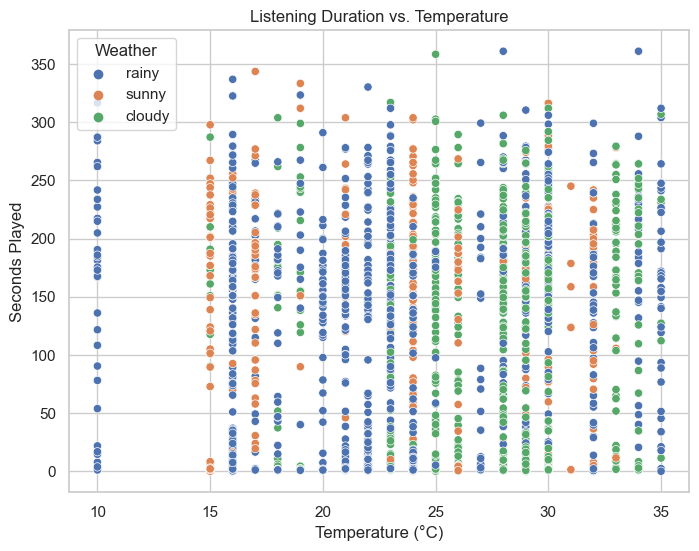

In [9]:
# Drop rows without temperature or sec_played
df_temp = df_merged.dropna(subset=['temperature','sec_played'])

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_temp,
    x='temperature',
    y='sec_played',
    hue='condition'
)
plt.title('Listening Duration vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Seconds Played')
plt.legend(title='Weather')
plt.show()

### 4.3 Heatmap of Genre Frequency by Weather
We can pivot `(condition, genre) -> count` into a 2D table, then plot as a heatmap.

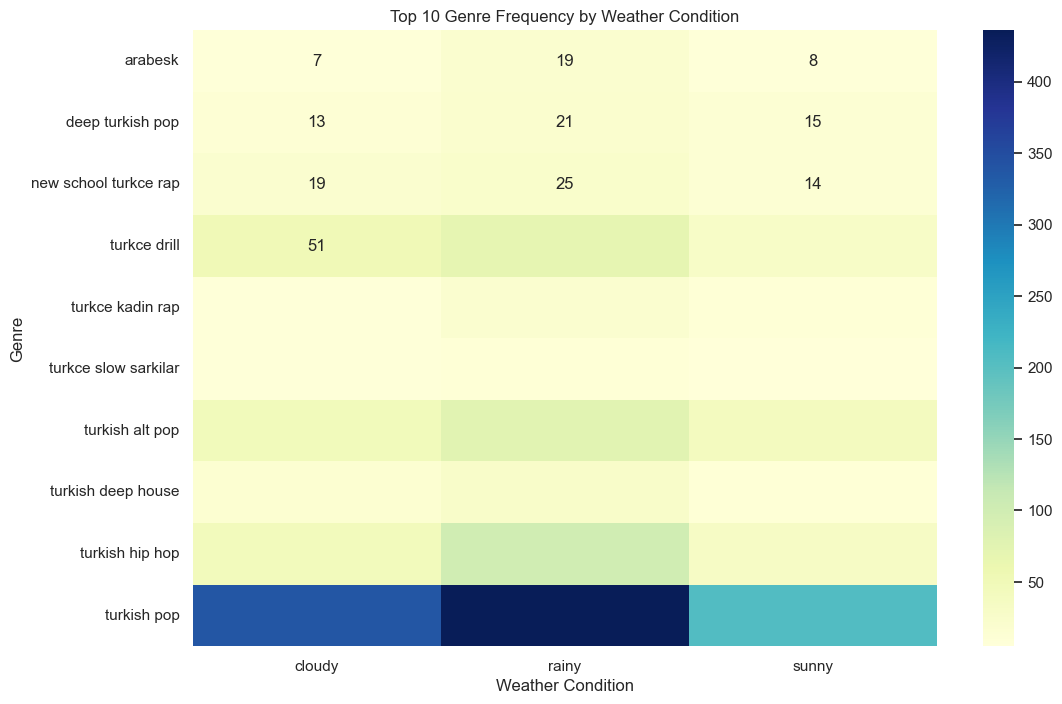

In [10]:
# Get the top 10 genres by frequency, excluding 'Unknown'
top_genres = df_end[df_end['genre'] != 'Unknown']['genre'].value_counts().head(10).index

# Filter the dataframe to include only the top 10 genres
df_top_genres = df_end[df_end['genre'].isin(top_genres)]

# Pivot the data to get the count of each genre under each weather condition
genre_weather_pivot = df_top_genres.pivot_table(
    index='genre',
    columns='condition',
    values='spotify_track_uri',
    aggfunc='count',
    fill_value=0
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(genre_weather_pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Top 10 Genre Frequency by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Genre')
plt.show()

```markdown
### Genre Frequency by Weather Condition

The heatmap aboove illustrates the frequency of the top 10 music genres played under different weather conditions (cloudy, rainy, sunny). Each cell represents the count of tracks played for a specific genre under a particular weather condition. 

- **turkish pop** is the most frequently played genre across all weather conditions, with the highest counts observed during rainy days.
- **turkish hip hop** and **turkish alt pop** also show significant play counts, particularly during rainy weather.
- **turkce drill** and **new school turkce rap** are more frequently played during rainy and cloudy conditions compared to sunny days.
- **deep turkish pop** and **turkish deep house** have moderate play counts across all weather conditions.
- **arabesk** and **turkce slow sarkilar** are less frequently played but still show some variation with weather conditions.

This visualization helps in understanding how different weather conditions might influence the my choice of music genres.
```

## 5. Simple Machine Learning
Whether I’ll listen to an **energetic** or **relaxing** genre on a given day based on the weather. 

### 5.1 Create a Target Label (Energetic vs. Relaxing)
We'll do something simplistic: if `genre` is `"turkish pop",
        "deep turkish pop",
        "new school turkce rap",
        "turkce drill",
        "turkce kadin rap",
        "turkish hip hop",
        "turkish alt pop",
        "turkish deep house"` or `"arabesk",
        "turkce slow sarkilar"`, I'll call it `'Energetic'`; otherwise `'Relaxing'`. This is obviously a big oversimplification, but it shows how the pipeline works.

In [ ]:
def energetic_or_relaxing(genre):
    energetic_genres = [
        "turkish pop",
        "deep turkish pop",
        "new school turkce rap",
        "turkce drill",
        "turkce kadin rap",
        "turkish hip hop",
        "turkish alt pop",
        "turkish deep house"
    ]
    relaxing_genres = [
        "arabesk",
        "turkce slow sarkilar"
    ]
    
    # Categorize based on lists
    if genre in energetic_genres:
        return "Energetic"
    elif genre in relaxing_genres:
        return "Relaxing"
    else:
        # Catch-all: if a genre isn't in one of the lists
        return "Other"

# Apply function to 'genre' column in df_end to create 'mood_label'
df_end['mood_label'] = df_end['genre'].apply(energetic_or_relaxing)

# Quick look at the results
df_end.head()


,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,sec_played,condition,temperature,humidity,track_id,track_name,artist_id,genres,genre,mood_label
0,2024-07-30 17:27:41+00:00,ios,133755,TR,176.33.67.245,DOĞUŞTAN BERİ HAKLIYIM (tmm),Lvbel C5,DOĞUŞTAN BERİ HAKLIYIM (tmm),spotify:track:2M7BEoyAzxLBKgnFQqUGmF,None,...,133.755,NaN,NaN,NaN,2M7BEoyAzxLBKgnFQqUGmF,DOĞUŞTAN BERİ HAKLIYIM (tmm),0V2oXYR7DtrZAEFeILRW2r,"turkce drill, turkish trap",turkce drill,Energetic
1,2024-07-30 17:32:04+00:00,ios,267354,TR,176.33.67.245,We Are The People,Empire Of The Sun,Walking On A Dream,spotify:track:6DG1vjbBFKJWVeihm4hK0X,None,...,267.354,NaN,NaN,NaN,6DG1vjbBFKJWVeihm4hK0X,We Are The People,67hb7towEyKvt5Z8Bx306c,"australian dance, australian electropop, dance...",australian dance,Other
2,2024-07-30 17:34:10+00:00,ios,5504,TR,176.33.67.245,DOĞUŞTAN BERİ HAKLIYIM (tmm),Lvbel C5,DOĞUŞTAN BERİ HAKLIYIM (tmm),spotify:track:2M7BEoyAzxLBKgnFQqUGmF,None,...,5.504,NaN,NaN,NaN,2M7BEoyAzxLBKgnFQqUGmF,DOĞUŞTAN BERİ HAKLIYIM (tmm),0V2oXYR7DtrZAEFeILRW2r,"turkce drill, turkish trap",turkce drill,Energetic
3,2024-07-30 17:34:11+00:00,ios,874,TR,176.33.67.245,nE !?,Lvbel C5,#1,spotify:track:1Ma4fLShd0hpZSNH37mEkR,None,...,0.874,NaN,NaN,NaN,1Ma4fLShd0hpZSNH37mEkR,nE !?,0V2oXYR7DtrZAEFeILRW2r,"turkce drill, turkish trap",turkce drill,Energetic
4,2024-07-31 13:36:38+00:00,ios,3221,TR,176.33.67.245,nE !?,Lvbel C5,#1,spotify:track:1Ma4fLShd0hpZSNH37mEkR,None,...,3.221,NaN,NaN,NaN,1Ma4fLShd0hpZSNH37mEkR,nE !?,0V2oXYR7DtrZAEFeILRW2r,"turkce drill, turkish trap",turkce drill,Energetic


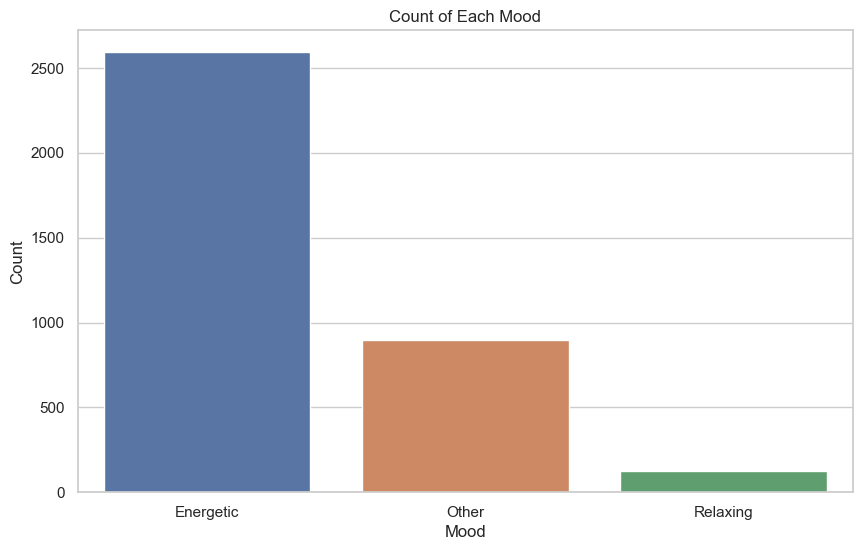

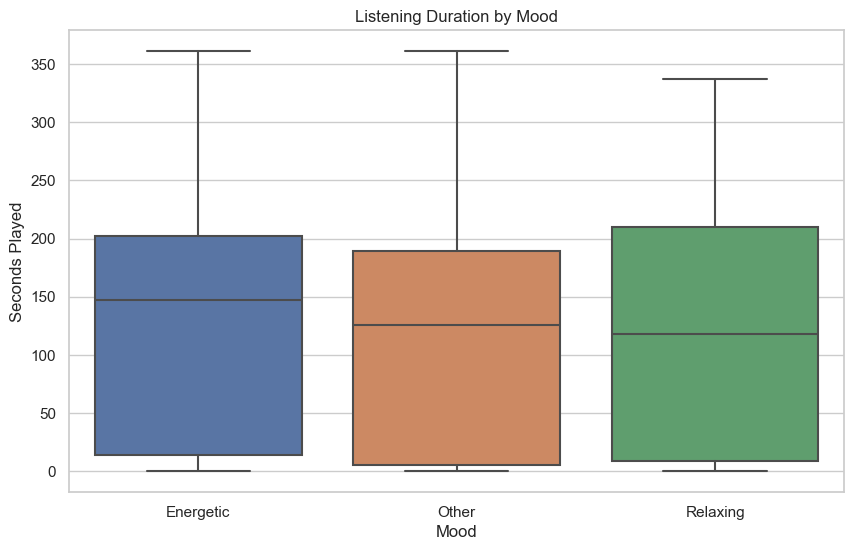

In [13]:
# Bar plot for mood counts
plt.figure(figsize=(10, 6))
sns.countplot(data=df_end, x='mood_label', order=df_end['mood_label'].value_counts().index)
plt.title('Count of Each Mood')
plt.xlabel('Mood')
plt.ylabel('Count')
plt.show()

# Box plot for listening duration by mood
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_end, x='mood_label', y='sec_played', order=df_end['mood_label'].value_counts().index)
plt.title('Listening Duration by Mood')
plt.xlabel('Mood')
plt.ylabel('Seconds Played')
plt.show()

### 5.2 Prepare Features and Target
We can use:
- Weather condition (categorical)
- Temperature (numeric)
- Possibly humidity or day-of-week

Then we predict `'mood_label'`: `'Energetic'` vs. `'Relaxing'`.

We’ll demonstrate a **Logistic Regression** model.

In [15]:
# Drop rows where we don't have condition or mood_label
df_ml = df_end.dropna(subset=['condition','mood_label']).copy()

df_ml.loc[:, 'condition'] = df_ml['condition'].astype(str)  # ensure it's string

# Encode condition (weather) as numeric
cond_encoder = LabelEncoder()
df_ml.loc[:, 'condition_encoded'] = cond_encoder.fit_transform(df_ml['condition'])

# Encode target
target_encoder = LabelEncoder()
df_ml.loc[:, 'mood_encoded'] = target_encoder.fit_transform(df_ml['mood_label'])

# Features: condition_encoded, temperature, optional humidity
X = df_ml[['condition_encoded', 'temperature']]  # add 'humidity' if you want: df_ml['humidity'].fillna(0)
X = X.fillna(0)  # just in case
y = df_ml['mood_encoded']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_encoder.classes_, zero_division=0))

Accuracy: 0.7366906474820144

Classification Report:
               precision    recall  f1-score   support

   Energetic       0.74      1.00      0.85       512
       Other       0.00      0.00      0.00       164
    Relaxing       0.00      0.00      0.00        19

    accuracy                           0.74       695
   macro avg       0.25      0.33      0.28       695
weighted avg       0.54      0.74      0.62       695



## 6. Summary & Next Steps
In this notebook, we:
1. **Loaded** Spotify listening data from a JSON file and extracted daily info.
2. **Merged** it with **weather data** on the daily level.
3. Performed basic **EDA** and visualizations, analyzing how weather might correlate with music listening (genre distribution, listening durations, etc.).
4. Showed a small **Machine Learning** demonstration, predicting `'Energetic'` vs. `'Relaxing'` genres from weather.

### Future Directions
- **Real Weather Data**: More Weather historical CSV to get actual conditions and more accuracy on ML algortihms.
- **Advanced ML**: I will try more features (time of day, day-of-week, user mood surveys) and more sophisticated models (Random Forest, XGBoost, etc.).
- **Time-Series Analysis**: I will look at changes in listening patterns over seasons, or track daily mood with a diary.